In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm, trange
import math
import umap
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Define function for centering the kernel
def centre_kernel(K):
    """Center a kernel matrix K"""
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

In [10]:
def lowrank_prefix_sampler_multiclass(B, T=1.0, q=5, seed=None):
    """
    Low-rank prefix sampler for the Potts / multi-class task-prior
        P(y) ∝ exp( β * Tr(Yᵀ K Y) ),   with  K ≈ B Bᵀ ,  β = 1/T.

    Parameters
    ----------
    B   : (n, r) ndarray       low-rank factor (e.g. Nyström or SVD) so K ≈ B Bᵀ
    T   : float                temperature (larger T ⇒ weaker couplings)
    q   : int                  number of classes (q = 5 by default)
    seed: int or None          random seed

    Returns
    -------
    labels : (n,) ndarray of ints in {0,…,q-1}
    """
    if seed is not None:
        np.random.seed(seed)

    n, r   = B.shape
    beta   = 1.0 / T
    labels = np.empty(n, dtype=np.int16)

    # running class-wise prefix sums   U[:, c] = Σ_{j<i, y_j=c} B[j]
    U = np.zeros((r, q), dtype=B.dtype)

    for i in range(n):
        # field for each class:   h_c = β · B[i]^T · U[:, c]
        h = beta * (B[i] @ U)        # shape (q,)

        # softmax to get conditional probabilities  P(y_i=c | prefix)
        h -= h.max()                 # numerical stabilisation
        p = np.exp(h)
        p /= p.sum()

        # sample the class
        c = np.random.choice(q, p=p)
        labels[i] = c

        # update the prefix accumulator for the chosen class
        U[:, c] += B[i]

    return labels

In [4]:
# List available kernel files
KERNEL_DIR = Path("kernels_out")
kernel_files = list(KERNEL_DIR.glob("K_*.pt"))

if not kernel_files:
    print("No kernel files found in 'kernels_out' directory!")
    print("Please run generate_timm_kernels.ipynb first.")
else:
    print(f"Found {len(kernel_files)} kernel files:")
    for i, f in enumerate(kernel_files):
        model_name = f.stem.split('_', 1)[1].rsplit('_', 1)[0]
        n_images = int(f.stem.split('_')[-1])
        print(f"[{i}] {model_name} ({n_images} images)")

Found 7 kernel files:
[0] convnext_base (2048 images)
[1] efficientnet_b5 (2048 images)
[2] resnet152 (2048 images)
[3] deit_base_patch16_224 (2048 images)
[4] resnet50 (2048 images)
[5] swin_base_patch4_window7_224 (2048 images)
[6] vit_base_patch16_224 (2048 images)


In [21]:
# Create dropdown widget to select kernel
kernel_options = [f.stem for f in kernel_files]
kernel_selector = widgets.Dropdown(
    options=kernel_options,
    description='Select kernel:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)
display(kernel_selector)

Dropdown(description='Select kernel:', layout=Layout(width='500px'), options=('K_convnext_base_2048', 'K_effic…

In [22]:
# Load the selected kernel
selected_kernel_file = KERNEL_DIR / f"{kernel_selector.value}.pt"
kernel_data = torch.load(selected_kernel_file)

K = kernel_data['K'].numpy()
Z = kernel_data['Z'].numpy()
indices = kernel_data['indices']
feat_dim = kernel_data['dim']

print(f"Loaded kernel: {kernel_selector.value}")
print(f"Kernel shape: {K.shape}")
print(f"Original feature dimension: {feat_dim}")

/tmp/ipykernel_15040/3130857176.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kernel_data = torch.load(selected_kernel_file)


Loaded kernel: K_swin_base_patch4_window7_224_2048
Kernel shape: (2048, 2048)
Original feature dimension: 50176


In [23]:
# Apply t-SNE for visualization
print("Computing t-SNE embedding...")
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(Z)
print("t-SNE completed.")

Computing t-SNE embedding...
t-SNE completed.


  0%|          | 0/9 [00:00<?, ?it/s]

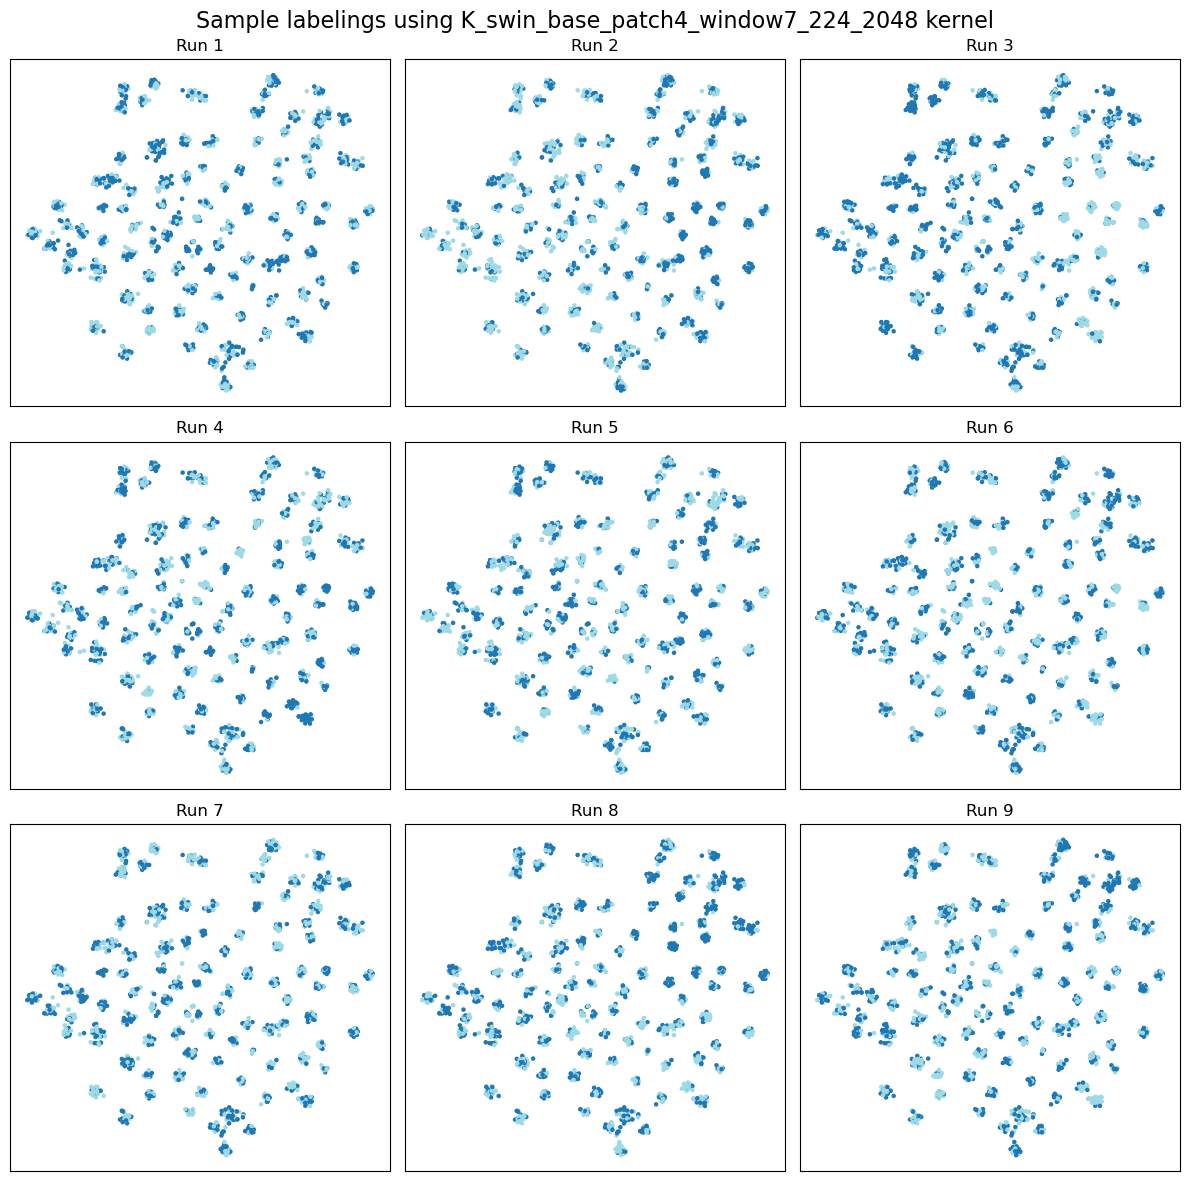

In [24]:
# Generate and visualize a sample of labelings
n_samples = 9
cols = 3
rows = math.ceil(n_samples / cols)

# Number of classes
n_classes = 2  # Can be adjusted using a widget if needed
temp = 50

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)
axes = axes.flatten()
sample_labels_list = []

# Center the kernel for low-rank sampling
centered_K = centre_kernel(K)

for i in trange(n_samples):
    # Generate labels
    labels_run = lowrank_prefix_sampler_multiclass(centered_K, T=temp, q=n_classes, seed=i)
    sample_labels_list.append(labels_run)
    
    # Plot
    ax = axes[i]
    scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1],
               c=labels_run, cmap="tab20", s=5, alpha=1)
    ax.set_title(f"Run {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any extra axes
for ax in axes[n_samples:]:
    ax.axis("off")

plt.suptitle(f"Sample labelings using {kernel_selector.value} kernel", fontsize=16)
plt.show()

In [25]:
# Generate a larger set of labelings for saving
n_runs = 256  # Number of different labelings to generate
labels_list = []

for i in trange(n_runs):
    labels_run = lowrank_prefix_sampler_multiclass(centered_K, T=temp, q=n_classes, seed=i)
    labels_list.append(labels_run)

  0%|          | 0/256 [00:00<?, ?it/s]

In [26]:
# Convert to numpy array and save
labels_array = np.array(labels_list)
print(f"Generated labels shape: {labels_array.shape}")

# Extract model name for the filename
model_name = kernel_selector.value.split('_', 1)[1].rsplit('_', 1)[0]
output_file = f"labels_mini_imagenet_{model_name}.npy"

np.save(output_file, labels_array)
print(f"Saved labels to {output_file}")

Generated labels shape: (256, 2048)
Saved labels to labels_mini_imagenet_swin_base_patch4_window7_224.npy


In [ ]:
# Save the UMAP embedding as well
umap_file = f"umap_mini_imagenet_{model_name}.npy"
np.save(umap_file, emb_2d)
print(f"Saved UMAP embedding to {umap_file}")

In [ ]:
# Create a widget to explore more individual labelings
def plot_specific_labeling(idx):
    plt.figure(figsize=(10, 8))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels_list[idx], cmap="tab20", s=5, alpha=1)
    plt.title(f"Labeling run {idx+1}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

run_selector = widgets.IntSlider(
    value=0,
    min=0,
    max=n_runs-1,
    step=1,
    description='Labeling run:',
    continuous_update=False
)

widgets.interactive(plot_specific_labeling, idx=run_selector)